In [3]:
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (AddMultibodyPlantSceneGraph,
                         DiagramBuilder,
                         InverseDynamicsController,
                         LeafSystem,
                         MeshcatVisualizer,
   
                         MultibodyPlant,
                         Parser, Simulator,
                         StartMeshcat,
                         StateInterpolatorWithDiscreteDerivative)

In [4]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


Assuming 1 controller for both robot and hand

In [5]:
robot_directives = '''

directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
- add_model:
    name: allegro
    file: package://drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: allegro::hand_root
    X_PC:
        translation: [0, 0, 0.05]
        rotation: !Rpy { deg: [0, 0, 0]}
'''


In [6]:
env_directives = """
directives:
- add_model:
    name: foam_brick
    file: package://drake/examples/manipulation_station/models/061_foam_brick.sdf
    default_free_body_pose:
        base_link:
            translation: [0.6, 0, 0]
- add_model:
    name: robot_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: robot_table::link
    X_PC:
        translation: [0, 0, -0.7645]
- add_model:
    name: work_table
    file: package://drake/examples/kuka_iiwa_arm/models/table/extra_heavy_duty_table_surface_only_collision.sdf
- add_weld:
    parent: world
    child: work_table::link
    X_PC:
        translation: [0.75, 0, -0.7645]
"""

In [7]:
builder = DiagramBuilder()
time_step = 0.002
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step)
parser = Parser(plant)

parser.AddModelsFromString(robot_directives, '.dmd.yaml')
parser.AddModelsFromString(env_directives, '.dmd.yaml')
plant.Finalize()

# second plant : for controller
controller_plant = MultibodyPlant(time_step)
Parser(controller_plant).AddModelsFromString(robot_directives, '.dmd.yaml')
controller_plant.Finalize()

num_positions = controller_plant.num_positions()




In [8]:
inv_dynamics_controller = builder.AddSystem(
    InverseDynamicsController(controller_plant, 
                              kp=[100] * num_positions,
                              ki=[1] * num_positions,
                              kd=[20] * num_positions,
                              has_reference_acceleration=False
                             )
)
inv_dynamics_controller.set_name('inv_dynamics_controller')

builder.Connect(inv_dynamics_controller.get_output_port(), 
               plant.get_actuation_input_port())


iiwa = plant.GetModelInstanceByName('iiwa')
allegro = plant.GetModelInstanceByName('allegro')



In [9]:
class CombineIiwaAndAllegroState(LeafSystem): 
    
    def __init__(self):
        LeafSystem.__init__(self)
        
        self.DeclareVectorInputPort(
            'iiwa_state', 
            plant.num_multibody_states(iiwa)
        )
        self.DeclareVectorInputPort(
            'allegro_state', 
            plant.num_multibody_states(allegro)
        )
        
        self.DeclareVectorOutputPort(
            "combined_state", 
            plant.num_multibody_states(iiwa) + plant.num_multibody_states(allegro), 
            self.CalcOutput
        )
        
        
    
    def CalcOutput(self, context, output): 
        iiwa_state = self.get_input_port(0).Eval(context)
        allegro_state = self.get_input_port(1).Eval(context)
        print(iiwa_state, allegro_state)
        
        output.SetFromVector(
            np.concatenate(
            (# è una tupla
                iiwa_state[:plant.num_positions(iiwa)],
                allegro_state[:plant.num_positions(allegro)],
                iiwa_state[plant.num_positions(iiwa):],
                allegro_state[plant.num_positions(allegro):]
            )
            )
        )
        

In [10]:
combined_state = builder.AddSystem(CombineIiwaAndAllegroState())

builder.Connect( plant.get_state_output_port(iiwa), 
                 combined_state.get_input_port(0)
               )

builder.Connect( plant.get_state_output_port(allegro), 
                 combined_state.get_input_port(1)
               )

builder.Connect( combined_state.get_output_port(),
                 inv_dynamics_controller.get_input_port_estimated_state()
               )

desired_state_from_position = builder.AddSystem(
    StateInterpolatorWithDiscreteDerivative(
        controller_plant.num_positions(),
        time_step,
        suppress_initial_transient=True))

builder.Connect(desired_state_from_position.get_output_port(),
                inv_dynamics_controller.get_input_port_desired_state())



In [11]:
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()


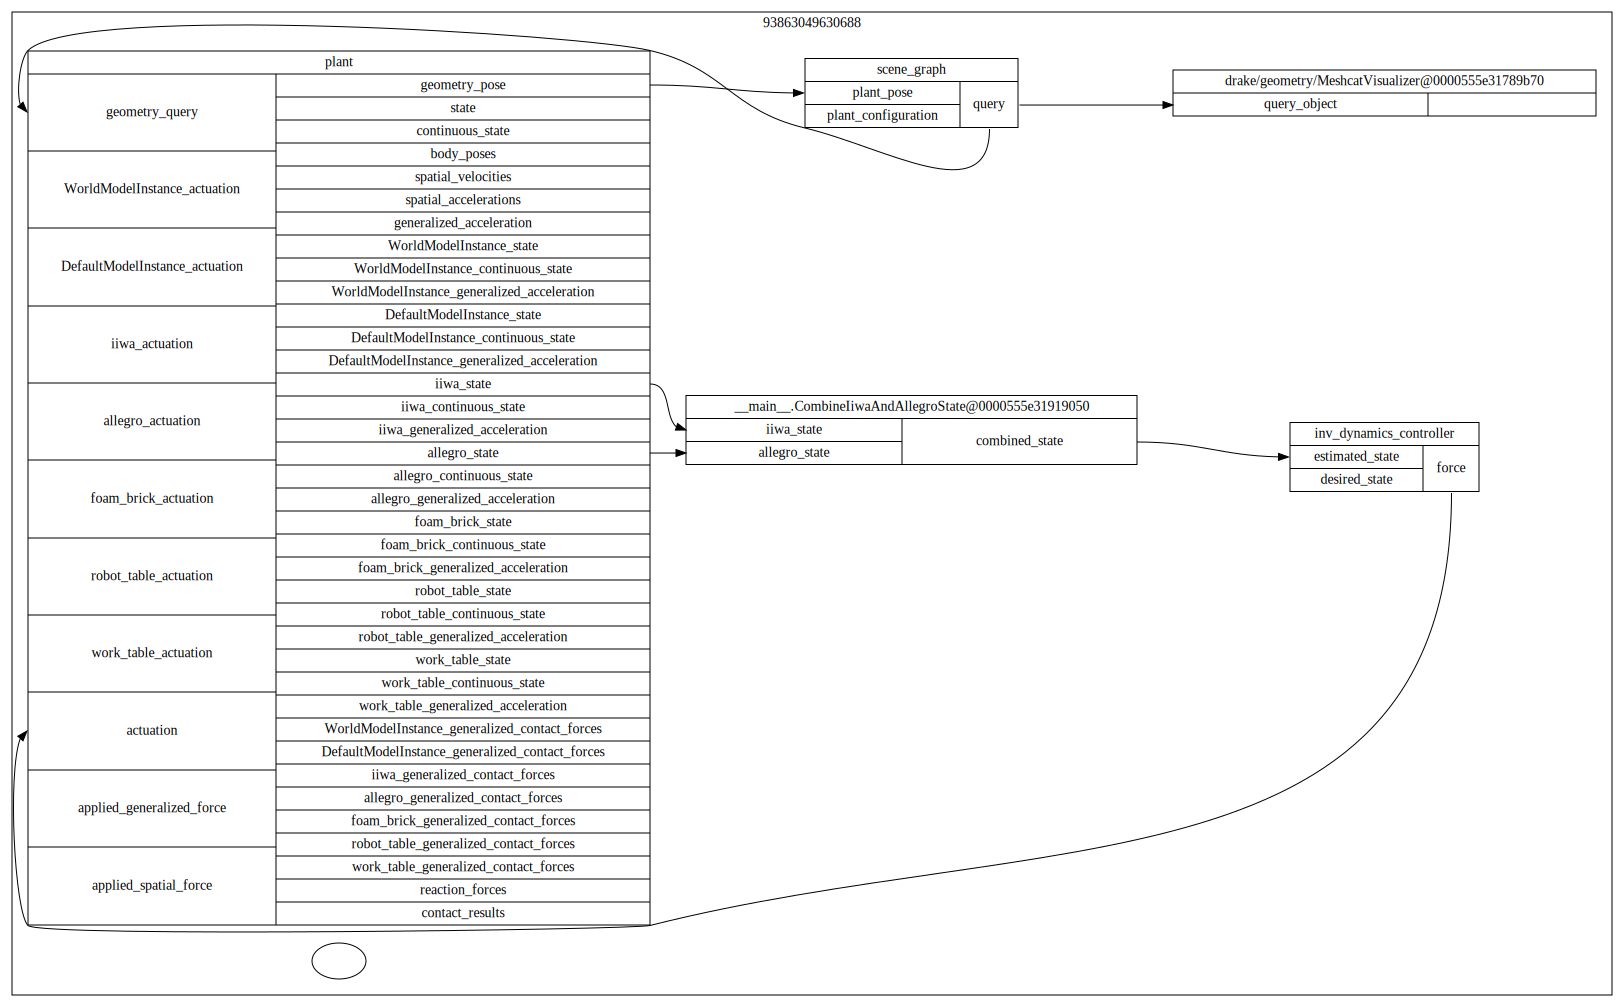

In [16]:
display(SVG(
    pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=1)
    )[0].create_svg()
))


In [12]:
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

q0 = combined_state.get_output_port().Eval(
    combined_state.GetMyMutableContextFromRoot(context)
)[:num_positions];


desired_state_from_position.get_input_port().FixValue(
    desired_state_from_position.GetMyMutableContextFromRoot(context), q0
)




[ 0.   0.1  0.  -1.2  0.   1.6  0.   0.   0.   0.   0.   0.   0.   0. ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
simulator.AdvanceTo(0.1)

[ 0.   0.1  0.  -1.2  0.   1.6  0.   0.   0.   0.   0.   0.   0.   0. ] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2.85030013e-09  1.00000014e-01  3.11069922e-10 -1.19999998e+00
  1.85884106e-07  1.59999935e+00  1.71857464e-05  1.42515006e-06
  7.22243858e-06  1.55534961e-07  1.13837305e-05  9.29420532e-05
 -3.23220507e-04  8.59287322e-03] [-1.77266048e-05  1.33864222e-05 -6.49015935e-06 -4.74759608e-06
  3.99945166e-05  2.36710324e-06  8.13699312e-07 -5.43039258e-07
 -1.72954745e-05  2.62916445e-06 -1.14035549e-06 -8.34142231e-07
 -1.67288439e-05 -8.16936334e-06  4.23042825e-06  3.09462357e-06
 -8.86330242e-03  6.69321111e-03 -3.24507968e-03 -2.37379804e-03
  1.99972583e-02  1.18355162e-03  4.06849656e-04 -2.71519629e-04
 -8.64773725e-03  1.31458223e-03 -5.70177746e-04 -4.17071115e-04
 -8.36442193e-03 -4.08468167e-03  2.11521413e-03  1.54731179e-03]
[ 2.85030013e-09  1.00000014e-01  3.11069922e-10 -1.19999998e+00
  1.85884106e-